In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import argparse
from pprint import pformat
from collections import OrderedDict
from src.model import AttentionModel
from src.composer import PsychRotation
from src.conductor import seq_cls_eval
from src.utils import plot_all
from src.utils import build_loaders
from prelude import get_device, startup_folders, load_dicts

import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import curve_fit
import numpy

# # fit a sigmoid function to the data
# def sigmoid(x, a, b, c):
#     return 1 / (1 + numpy.exp(-a * (x - b))) + c

# def fit_sigmoid(x, y):
#     x = numpy.array(x) if not isinstance(x, numpy.ndarray) else x
#     y = numpy.array(y) if not isinstance(y, numpy.ndarray) else y

#     # Initial guess for the parameters
#     initial_guess = [1, numpy.mean(x), 0]

#     # Fit the sigmoid function to the data
#     params, _ = curve_fit(sigmoid, x, y, p0=initial_guess)
#     # params, _ = curve_fit(sigmoid, x, y, p0=initial_guess, bounds=([0, 0, 0], [numpy.inf, numpy.inf, 1]))

    # return params

# fit a sigmoid function to the data
def sigmoid(x, a, b, c, d):
    return d + (c / (1 + numpy.exp(-a * (x - b))))

def fit_sigmoid(x, y):
    x = numpy.array(x) if not isinstance(x, numpy.ndarray) else x
    y = numpy.array(y) if not isinstance(y, numpy.ndarray) else y

    # Initial guess for the parameters
    initial_guess = [1.0, numpy.mean(x), 1.0, 0.0]

    # Fit the sigmoid function to the data
    params, _ = curve_fit(sigmoid, x, y, p0=initial_guess)
    # params, _ = curve_fit(sigmoid, x, y, p0=initial_guess, bounds=([0, 0, 0], [numpy.inf, numpy.inf, 1]))

    return params

# # fit a sigmoid function to the data
# def sigmoid(x, a, b):
#     return 1 / (1 + numpy.exp(-a * (x - b)))

# def fit_sigmoid(x, y):
#     x = numpy.array(x) if not isinstance(x, numpy.ndarray) else x
#     y = numpy.array(y) if not isinstance(y, numpy.ndarray) else y

#     # Initial guess for the parameters
#     initial_guess = [1, numpy.mean(x)]

#     # Fit the sigmoid function to the data
#     params, _ = curve_fit(sigmoid, x, y, p0=initial_guess, bounds=)

#     return params


In [4]:
start_folder = r"../results/Psycho/1749060793"
results_folder, logger = startup_folders(start_folder, name=f"exp_a")
data_path = r"../data"

../results/Psycho/1749060793/1749736208 was created!


In [5]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")
train_params["batch_size"] = 256
tasks

Device set to mps
model_params: {'in_dims': [1, 96, 96], 'n_classes': 9, 'out_dim': 9, 'normalize': True, 'softness': 0.5, 'channels': [1, 4, 8, 16, 32, 32], 'residuals': False, 'kernels': 3, 'strides': 2, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': ReLU(), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'pools': [1, 1, 1, 1, 1], 'rnn_dims': [16, 8], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': ReLU(), 'n_tasks': 1, 'task_layers': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'norm_mean': [0.5], 'norm_std': [0.25], 'rnn_to_fc': False, 'trans_fun': Identity()}
tasks: {'RotationChangeDetection': {'composer': 'PsychRotation', 'key': 0, 'params': {'episodes': [0, 2, 1, 3], 'm_range': 30, 'm_base': 5, 'biased': 0.0, 'relative': -1, 'force_range': False, 'force_label': False, 'noise': 0.25}, 'datasets': ['PsychRotation', 'PsychRotation', 'PsychRotation

{'RotationChangeDetection': {'composer': 'PsychRotation',
  'key': 0,
  'params': {'episodes': [0, 2, 1, 3],
   'm_range': 30,
   'm_base': 5,
   'biased': 0.0,
   'relative': -1,
   'force_range': False,
   'force_label': False,
   'noise': 0.25},
  'datasets': ['PsychRotation', 'PsychRotation', 'PsychRotation'],
  'dataloaders': [None, None, None],
  'loss_w': [[1.0, 1.0], None],
  'loss_s': [[-2, -1], None]}}

In [6]:
# datasets and dataloaders
o = "RotationChangeDetection"
tasks[o]["composer"] = PsychRotation
tasks[o]["datasets"] = []
tasks[o]["dataloaders"] = []

# datasets and dataloaders
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=train_params["n_samples"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# create a blank model
model = AttentionModel(**model_params)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [7]:
ce_loss, accuracy, mask_loss = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=True)
print(f"CE Loss: {ce_loss}, Accuracy: {accuracy}, Mask Loss: {mask_loss}")

Validating...
	 -2 CE-Loss: 0.5884
	 -2 Acc: 0.8203
	 -1 CE-Loss: 0.2777
	 -1 Acc: 0.9248


CE Loss: [0.5883630365133286, 0.27768414467573166], Accuracy: [0.8203125, 0.9248046875], Mask Loss: []


In [9]:
o = "RotationChangeDetection"
theta_range = list(range(1, 31, 1))
cue_range = (0, 1, 2, 3)
ce_stuff = [[[] for _ in tasks[o]["loss_s"][0]] for _ in cue_range]
acc_stuff = [[[] for _ in tasks[o]["loss_s"][0]] for _ in cue_range]
for k, r in enumerate(cue_range):
    for j, rng in enumerate(theta_range):
        tasks[o]["dataloaders"][1].dataset.m_range = rng
        tasks[o]["dataloaders"][1].dataset.m_base = 1
        tasks[o]["dataloaders"][1].dataset.relative = r
        tasks[o]["dataloaders"][1].dataset.biased = 0.0
        tasks[o]["dataloaders"][1].dataset.force_range = True
        tasks[o]["dataloaders"][1].dataset.force_label = True
        tasks[o]["dataloaders"][1].dataset.n_samples = 512
        ce_, acc_, mask_ = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=False)
        for i, _ in enumerate(tasks[o]["loss_s"][0]):
            ce_stuff[k][i].append(ce_[i])
            acc_stuff[k][i].append(acc_[i])

ce_stuff = torch.tensor(ce_stuff)
acc_stuff = torch.tensor(acc_stuff)
print(f"CE Stuff: {ce_stuff.shape}, Acc Stuff: {acc_stuff.shape}")


CE Stuff: torch.Size([4, 2, 30]), Acc Stuff: torch.Size([4, 2, 30])


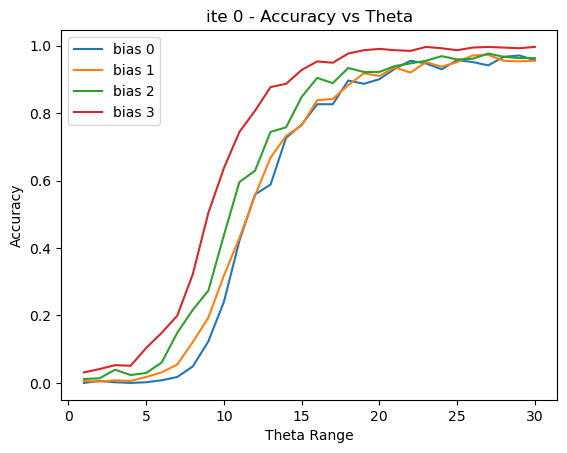

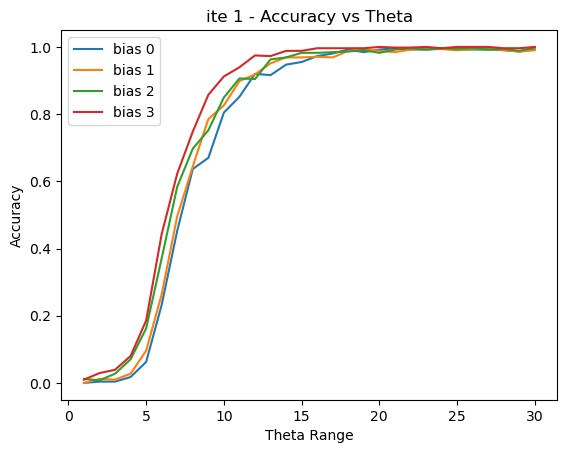

In [10]:
for i in (0, 1):
    for k, r in enumerate(cue_range):
        plt.plot(theta_range, acc_stuff[k, i, :], label=f"bias {r}")
    plt.xlabel("Theta Range")
    plt.ylabel("Accuracy")
    plt.title(f"ite {i} - Accuracy vs Theta")
    plt.legend()
    plt.savefig(os.path.join(results_folder, f"ite_{i}_acc_vs_theta.svg"), format="svg")
    plt.show()
    

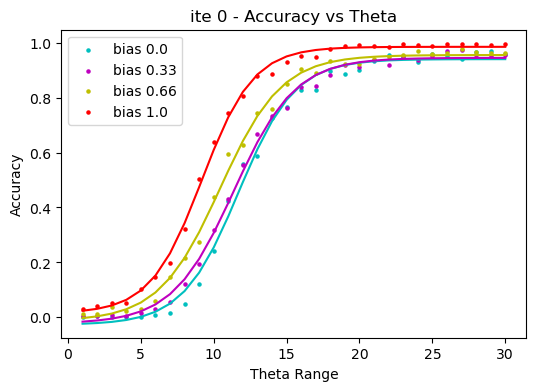

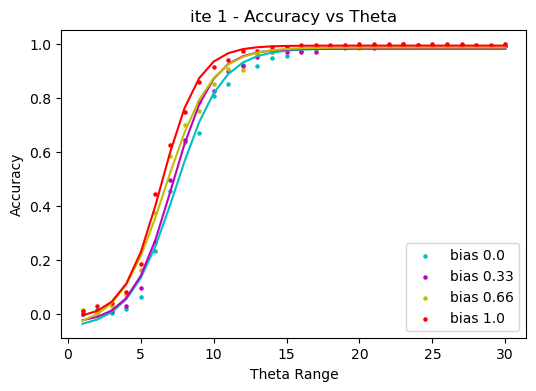

In [15]:
colors = ["c", "m", "y", "r"]
biases = [0.0, 0.33, 0.66, 1.0]
for i in (0, 1):
    plt.figure(figsize=(6, 4))
    for k, r in enumerate(cue_range):
        x = torch.tensor(theta_range)
        y = acc_stuff[k, i, :]
        params = fit_sigmoid(x, y)
        plt.scatter(x, y,  color=colors[k], label=f"bias {biases[k]}", s=5)
        plt.plot(x, sigmoid(x, *params), color=colors[k])
    plt.xlabel("Theta Range")
    plt.ylabel("Accuracy")
    plt.title(f"ite {i} - Accuracy vs Theta")
    plt.legend()
    plt.savefig(os.path.join(results_folder, f"f_ite_{i}_acc_vs_theta.svg"), format="svg")
    plt.show()
    

In [ ]:
model.to(DeVice)
x, y, m, *_ = next(iter(tasks[o]["dataloaders"][1]))
x, y, m = x.to(DeVice), y.to(DeVice), m.to(DeVice)
masks_, labels_, act_ = model(x)


In [ ]:
act_[-4].shape

In [ ]:
plt.imshow(m[1, -1, 0].detach().cpu())

In [ ]:
plt.imshow(act_[-3][1, -1].sum(dim=0).detach().cpu())

In [ ]:
STOP

In [ ]:
o = "RotationChangeDetection"
theta_range = list(range(1, 31, 1))
bias_range = [0.01, 0.5, 1.0]
ce_stuff = [[[] for _ in tasks[o]["loss_s"][0]] for _ in bias_range]
acc_stuff = [[[] for _ in tasks[o]["loss_s"][0]] for _ in bias_range]
for k, r in enumerate(bias_range):
    for j, rng in enumerate(theta_range):
        tasks[o]["dataloaders"][1].dataset.m_range = rng
        tasks[o]["dataloaders"][1].dataset.m_base = 1
        tasks[o]["dataloaders"][1].dataset.relative = None
        tasks[o]["dataloaders"][1].dataset.biased = r
        tasks[o]["dataloaders"][1].dataset.force_range = True
        tasks[o]["dataloaders"][1].dataset.force_label = True
        tasks[o]["dataloaders"][1].dataset.n_samples = 128
        ce_, acc_, mask_ = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=False)
        for i, _ in enumerate(tasks[o]["loss_s"][0]):
            ce_stuff[k][i].append(ce_[i])
            acc_stuff[k][i].append(acc_[i])

ce_stuff = torch.tensor(ce_stuff)
acc_stuff = torch.tensor(acc_stuff)
print(f"CE Stuff: {ce_stuff.shape}, Acc Stuff: {acc_stuff.shape}")

In [ ]:
for i in (0, 1):
    for k, r in enumerate(bias_range):
        plt.plot(theta_range, acc_stuff[k, i, :], label=f"bias {r}")
    plt.xlabel("Theta Range")
    plt.ylabel("Accuracy")
    plt.title(f"ite {i} - Accuracy vs Theta")
    plt.legend()
    plt.savefig(os.path.join(results_folder, f"ite_{i}_acc_vs_theta.svg"), format="svg")
    plt.show()

In [ ]:
for i in cue_range:
    plt.plot(theta_range, acc_stuff[i, 0, :], label=f"cue {i}")
plt.xlabel("Theta Range")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Theta Range for different Cues")
plt.legend()
plt.show()


In [ ]:
o = "RotationChangeDetection"
tasks[o]["dataloaders"][1].dataset.m_range = 30
tasks[o]["dataloaders"][1].dataset.n_samples = 128
tasks[o]["dataloaders"][1].dataset.force_range = False
tasks[o]["dataloaders"][1].dataset.force_label = True
tasks[o]["dataloaders"][1].dataset.force_locations = False
tasks[o]["dataloaders"][1].dataset.force_alignment = False


In [ ]:
o = "RotationChangeDetection"
theta_range = list(range(1, 31, 1))
ce_stuff, acc_stuff = [], []
for j, rng in enumerate(theta_range):
    tasks[o]["dataloaders"][1].dataset.biased = 0.0
    tasks[o]["dataloaders"][1].dataset.m_range = rng
    tasks[o]["dataloaders"][1].dataset.n_samples = 128
    tasks[o]["dataloaders"][1].dataset.force_range = True
    tasks[o]["dataloaders"][1].dataset.force_label = True
    tasks[o]["dataloaders"][1].dataset.force_locations = True
    tasks[o]["dataloaders"][1].dataset.force_alignment = True
    ce_, acc_ = ep_cls_eval(model, tasks, DeVice, logger, True, 0.75, (3, ), False)
    ce_stuff.append(ce_[0])
    acc_stuff.append(acc_[0])


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import math
from src.composer import gaussian_patch, gabor, routine_01

class ChangeDet(Dataset):
    def __init__(self,
                 dataset_: Dataset,
                 episodes: tuple = (2, 3, 2),
                 n_gabors: int = 2,
                 m_range: int = 30,
                 m_base: int = 6,
                 noise: float = 0.25,
                 biased: float = 0.0,
                 relative: bool = False,
                 stop_interference: bool = False,
                 force_range: bool = False,
                 force_label: bool = False,
                 force_locations: bool = False,
                 force_alignment: bool = False,
                 ):
        super().__init__()
        self.dataset = dataset_
        self.n_ep = episodes
        self.n_iter = sum(self.n_ep)
        self.n_gabs = n_gabors
        self.hh, self.ww = 32, 32
        self.g = 3
        self.h, self.w = self.g * self.hh, self.g * self.ww
        self.gg = self.g * self.g
        self.m_range = m_range
        self.m_base = m_base
        self.noise = noise
        self.biased = biased
        self.relative = relative
        self.stin = stop_interference
        self.force_range = force_range
        self.force_label = force_label
        self.force_locations = force_locations
        self.force_alignment = force_alignment
        self.n_samples = len(self.dataset)
        self.center_off_locations = torch.tensor([0, 1, 2, 3, 5, 6, 7, 8])
        self.raw_gabors = self.load_gabors()
        self.gaussian = gaussian_patch(self.hh, self.ww, 8.0)**0.5
        self.cue_trans = transforms.RandomRotation(degrees=180)
        self.digit_trans = transforms.Compose([
            transforms.Pad((2, 2)),
            transforms.RandomRotation(degrees=15),
        ])
        
    def load_gabors(self):
        z = gaussian_patch(64, 64, 12.0)
        gabors = torch.zeros(180, 1, 64, 64)
        for i in range(180):
            x = gabor(64, 64, 0.75, i * math.pi / 180.0, 12.0)
            gabors[i, 0] = x * z
            gabors[i, 0] /= gabors[i, 0].max()  # normalize to [0, 1]
        return transforms.Resize((self.hh, self.ww), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)(gabors)

    def make_slice(self, i: int, j: int):
        h_slice = slice(i * self.hh, (i + 1) * self.hh)
        w_slice = slice(j * self.ww, (j + 1) * self.ww)
        return h_slice, w_slice

    def build_valid_test(self):
        # self.noise = 0.0
        pass

    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        if self.force_alignment:
            while True:
                x1, y1 = self.dataset[torch.randint(0, self.n_samples, ())]
                if y1 in self.center_off_locations:
                    break
        else:
            x1, y1 = self.dataset[idx]
        x2, y2 = self.dataset[torch.randint(0, self.n_samples, ())]
        x1 = self.digit_trans(x1.unsqueeze(0))
        # x1, y1 = self.dataset[idx]
        # x1 = self.digit_trans(x1.unsqueeze(0))
        x2 = self.digit_trans(x2.unsqueeze(0))
        composites = torch.zeros(self.n_iter, 1, self.h, self.w)
        labels = torch.zeros(self.n_iter, dtype=torch.long)
        masks = torch.zeros(self.n_iter, 1, self.h, self.w)
        components = 0
        hot_labels = 0

        # Random place locations
        rand_locs = torch.randperm(self.gg)[:2]
        rand_locs[0] = rand_locs[1] = y1 if self.force_alignment else rand_locs[0]  # ensure the first location is aligned with the first digit
        rand_locs[1] = rand_locs[0] if self.force_locations else rand_locs[1]  # ensure the second location is the same as the first
        i1, j1 = divmod(rand_locs[0].item(), 3)
        i2, j2 = divmod(rand_locs[1].item(), 3)
        si, sj = self.make_slice(i1, j1)
        composites[:self.n_ep[0], :, si, sj] = x1
        labels[:self.n_ep[0]] = y1
        masks[:self.n_ep[0], :, si, sj] = x1
        si, sj = self.make_slice(i2, j2)
        composites[-self.n_ep[-1]:, :, si, sj] = x2
        labels[-self.n_ep[-1]:] = y2
        masks[-self.n_ep[-1]:, :, si, sj] = x2

        # Gabor stuff
        pp = self.center_off_locations[torch.randperm(8)]  # avoid center position (4)
        n_g = torch.randint(1, self.n_gabs + 1, (())).item()
        g_locations = pp[:n_g].tolist()
        if self.force_locations:
            g_locations[0] = rand_locs[0].item()
        elif rand_locs[0].item() in self.center_off_locations:
            if self.relative and torch.rand(()) < (0.1 * y1):
                g_locations[0] = rand_locs[0].item()
            elif torch.rand(()) < self.biased:
                g_locations[0] = rand_locs[0].item()

        # g_locations[0] = rand_locs[0].item() if self.force_locations else g_locations[0]  # ensure the first Gabor is aligned with the first digit

        g_slc = slice(self.n_ep[0], -self.n_ep[-1])
        g_motions = torch.randint(-self.m_base, self.m_base, (n_g, self.n_ep[1]))
        g_motions = g_motions + torch.randint(0, 180, (n_g, 1))
        y_g = g_locations[0] if (torch.rand(()) < 0.5 or self.force_label) else 4
        labels[g_slc] = (y_g + 10) if self.stin else y_g
        if self.force_range:
            m_delta = self.m_range
        else:
            m_delta = torch.randint(self.m_base, self.m_range, (()))
            m_delta = (-1 if torch.rand(()) < 0.5 else 1) * m_delta
        if y_g != 4:
            g_motions[0, :] = g_motions[0, :] + (m_delta * torch.arange(self.n_ep[1])).long()
        g_motions = g_motions % 180

        for k, loc in enumerate(g_locations):
            i, j = divmod(loc, 3)
            h_slice, w_slice = self.make_slice(i, j)
            composites[g_slc, :, h_slice, w_slice] = self.raw_gabors[g_motions[k]]
            if loc == y_g:
                masks[g_slc, :, h_slice, w_slice] = self.gaussian
 
        composites, masks = routine_01(composites, masks, self.noise)
        return composites, labels, masks, components, hot_labels


In [ ]:
# # built-in modules
import time
from logging import Logger
import os
# # Torch modules
import torch
from torch.nn.functional import cross_entropy, mse_loss
from torch.nn.utils import clip_grad_norm_


def draw_episodes(episodes, p: float = None, c: bool = False):
    ep1, ep2, ep3 = episodes
    p = torch.rand(()) if p is None else p
    if p > 0.9:
        n_iter = ep1 + ep2 + ep3
        ep_slc = slice(0, None)
        pe_slc = None
    elif p > 0.7:
        n_iter = ep1 + ep2
        ep_slc = slice(0, ep1 + ep2)
        pe_slc = None
    elif p > 0.5:
        n_iter = ep2 + ep3
        ep_slc = slice(ep1, None)
        pe_slc = slice(0, ep1)
    elif p > 0.25:
        n_iter = ep1
        ep_slc = slice(0, ep1)
        pe_slc = None
    else:
        n_iter = ep2
        ep_slc = slice(ep1, ep1 + ep2)
        pe_slc = slice(0, ep1)
    if c:
        return n_iter, ep_slc, pe_slc
    else:
        return n_iter, ep_slc

def ep_cls_train(
    model: AttentionModel, 
    tasks: dict,
    optimizer: torch.optim.Adam, 
    scheduler: torch.optim.lr_scheduler.LRScheduler, 
    n_epochs: int,
    device: torch.device,
    logger: Logger,
    max_grad_norm: float = 10.0,
):
    logger.info("Training...")
    loss_log, eval_log = [], [[[], []] for _ in range(5)]
    task_content = next(iter(tasks.values()))
    train_dl = task_content["dataloaders"][0]
    loss_s = task_content["loss_s"][0]
    episodes = task_content["episodes"]
    n_bs = len(train_dl)
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        epoch_t = time.time()
        for x, y, *_ in train_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            # n_iter, ep_slc = draw_episodes(episodes)
            n_iter, ep_slc = draw_episodes(episodes, p=0.75)
            asloss = torch.arange(y.size(1)).tolist()[ep_slc]
            p_m, p_y, a_ = model(x[:, ep_slc])
            loss = 0.0
            for i, s in enumerate(asloss):
                if s in loss_s:
                    loss = loss + cross_entropy(p_y[:, :, i], y[:, i])
            loss.backward()
            clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            loss_log.append(loss.item())

        if scheduler is not None:
            if not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            logger.info(f"lr: {scheduler.get_last_lr()}")

        logger.info(f"Epoch {epoch} in {time.time()-epoch_t:.2f} sec")
        logger.info(f"\t CE-Loss: {sum(loss_log[-n_bs:])/n_bs:.4f}")

        val_ce, val_acc = ep_cls_eval(model, tasks, device, logger)
        for i in range(5):
            eval_log[i][0].append(val_ce[i])
            eval_log[i][1].append(val_acc[i])

    model.eval()
    return loss_log, eval_log


def ep_cls_eval(
    model: AttentionModel, 
    tasks: dict,
    device: torch.device,
    logger: Logger,
    valid: bool = True,
    p_force: float = None,
    s_force: tuple = None,
    verbose: bool = True,
):
    ce_loss = [0.0 for _ in range(5)]
    accuracy = [0 for _ in range(5)]
    task_content = next(iter(tasks.values()))
    loss_s = task_content["loss_s"][0] if s_force is None else s_force
    episodes = task_content["episodes"]
    this_dl = task_content["dataloaders"][1] if valid else task_content["dataloaders"][2]
    n_bs = len(this_dl.dataset)
    verbose and logger.info("Validating..." if valid else "Testing...")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for k, p in enumerate((0.05, 0.3, 0.55, 0.75, 0.95) if p_force is None else (p_force,)):
        # for k, p in enumerate((0.05, 0.3, 0.75)):
            n_iter, ep_slc = draw_episodes(episodes, p)
            for x, y, _, _, _ in this_dl:
                x, y = x.to(device), y.to(device)
                asloss = torch.arange(y.size(1)).tolist()[ep_slc]
                p_m, p_y, a_ = model(x[:, ep_slc])
                for i, s in enumerate(asloss):
                    if s in loss_s:
                        ce_loss[k] = ce_loss[k] + cross_entropy(p_y[:, :, i], y[:, i], reduction='sum').item()
                        accuracy[k] = accuracy[k] + (p_y[:, :, i].argmax(dim=1) == y[:, i]).sum().item()
            ce_loss[k] = ce_loss[k]/n_bs
            accuracy[k] = accuracy[k]/n_bs
            verbose and logger.info(f"\t {ep_slc} CE-Loss: {ce_loss[k]:.4f}")
            verbose and logger.info(f"\t {ep_slc} Acc: {accuracy[k]:.4f}")
    return ce_loss, accuracy


In [ ]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")
tasks['RotationChangeDetection']

In [ ]:
# datasets and dataloaders
o = "RotationChangeDetection"
tasks[o]["composer"] = ChangeDet
tasks[o]["datasets"] = []
tasks[o]["dataloaders"] = []
# tasks[o]["loss_s"] = ([1, 4, 6], None)
tasks[o]["loss_s"] = ([0, 1, 2, 3, 4, 5, 6], None)
tasks[o]["params"]["force_range"] = False
tasks[o]["params"]["force_label"] = True
tasks[o]["params"]["force_locations"] = False
tasks[o]["params"]["force_alignment"] = False

mnist_trval = torchvision.datasets.MNIST(data_path, train=True, download=False, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(data_path, train=False, download=False, transform=torchvision.transforms.ToTensor())
mnist_train, mnist_valid = torch.utils.data.random_split(mnist_trval, [50000, 10000])
DeVice, num_workers, pin_memory = get_device()
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](mnist_train, **tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](mnist_valid, **tasks[o]["params"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](mnist_test, **tasks[o]["params"]))
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# create a blank model
model = AttentionModel(**model_params)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

In [ ]:
o = "RotationChangeDetection"
tasks[o]["dataloaders"][1].dataset.m_range = 30
tasks[o]["dataloaders"][1].dataset.n_samples = 128
tasks[o]["dataloaders"][1].dataset.force_range = False
tasks[o]["dataloaders"][1].dataset.force_label = True
tasks[o]["dataloaders"][1].dataset.force_locations = False
tasks[o]["dataloaders"][1].dataset.force_alignment = False
ep_cls_eval(model, tasks, DeVice, logger, True, 0.05, (3, ))

In [ ]:
o = "RotationChangeDetection"
theta_range = list(range(1, 31, 1))
ce_stuff, acc_stuff = [], []
for j, rng in enumerate(theta_range):
    tasks[o]["dataloaders"][1].dataset.biased = 0.0
    tasks[o]["dataloaders"][1].dataset.m_range = rng
    tasks[o]["dataloaders"][1].dataset.n_samples = 128
    tasks[o]["dataloaders"][1].dataset.force_range = True
    tasks[o]["dataloaders"][1].dataset.force_label = True
    tasks[o]["dataloaders"][1].dataset.force_locations = True
    tasks[o]["dataloaders"][1].dataset.force_alignment = True
    ce_, acc_ = ep_cls_eval(model, tasks, DeVice, logger, True, 0.75, (3, ), False)
    ce_stuff.append(ce_[0])
    acc_stuff.append(acc_[0])


In [ ]:
plt.plot(theta_range, acc_stuff)
plt.ylim(0, 1)
plt.xlabel("Theta Range")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Theta Range")
# plt.legend()


In [ ]:
# evaluating...
plot_all(10, model, tasks, results_folder, "_test", DeVice, logger, False, "test")


In [ ]:
all_eval_scores = []
theta_range = list(range(1, 31, 1))
n_attend = tasks[o]["params"]["fix_attend"][1]
all_class_probs = torch.zeros(4, len(theta_range), n_attend, 128)
for i, knd in enumerate((0, 1, 2, 3)):
    all_eval_scores.append([])
    for j, rng in enumerate(theta_range):
        for o in tasks:
            tasks[o]["datasets"] = []
            tasks[o]["dataloaders"] = []
            tasks[o]["params"]["n_samples"] = 128
            tasks[o]["params"]["m_range"] = rng
            tasks[o]["params"]["m_base"] = 1
            tasks[o]["params"]["force_range"] = True
            tasks[o]["params"]["force_kind"] = knd
            tasks[o]["params"]["force_label"] = True
            tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
            tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
            tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"]))
            tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

        conductor = AttentionTrain(model, None, None, tasks, logger, results_folder)
        eval_scores, class_probs = conductor.eval_seq(DeVice, "test", None, True)
        eval_scores = torch.tensor(eval_scores[-n_attend:])[:, -1].tolist()
        class_probs = torch.stack(class_probs[-n_attend:])
        all_eval_scores[-1].append(eval_scores)
        all_class_probs[i, j] = class_probs
all_eval_scores = torch.tensor(all_eval_scores)


In [ ]:
mean_, std_ = all_class_probs.mean(dim=-1), all_class_probs.std(dim=-1)
print(mean_.shape, std_.shape)


In [ ]:
t_ = 0
m1, m2, m3, m4 = mean_[0, :, t_], mean_[1, :, t_], mean_[2, :, t_], mean_[3, :, t_]
s1, s2, s3, s4 = std_[0, :, t_], std_[1, :, t_], std_[2, :, t_], std_[3, :, t_]
plt.plot(theta_range, m1, label="knd=0", color="blue")
plt.fill_between(theta_range, m1 - s1, m1 + s1, color="blue", alpha=0.2)
plt.plot(theta_range, m2, label="knd=1", color="orange")
plt.fill_between(theta_range, m2 - s2, m2 + s2, color="orange", alpha=0.2)
plt.plot(theta_range, m3, label="knd=2", color="green")
plt.fill_between(theta_range, m3 - s3, m3 + s3, color="green", alpha=0.2)
plt.plot(theta_range, m4, label="knd=3", color="red")
plt.fill_between(theta_range, m4 - s4, m4 + s4, color="red", alpha=0.2)

In [ ]:
t_ = 0
plt.plot(all_eval_scores[0, :, t_], label="knd=0")
plt.plot(all_eval_scores[1, :, t_], label="knd=1")
plt.plot(all_eval_scores[2, :, t_], label="knd=2")
plt.plot(all_eval_scores[3, :, t_], label="knd=3")
plt.legend()